# Modelo de clasificación mediante la técnica de Fine-Tunning

- Modelo inspirado en el libro *Natural Language Processing with Transformers*.
- Aplicación al modelo de Imagen México para tres clases.

Luis Norberto Zúñiga Morales, Jose Emilio Quiroz Ibarra, César Villanueva Rivas

## Una breve introducción

En el 2017, investigadores de Google publicaorn el (ahora famoso) artículo que introdujo al Transformer, una red neuronal profunda cuya arquitectura permitió superar modelos que conformaban el estado del arte en ese tiempo, como las *Long Short-Term Memory* (LSTM). Este nuevo modelo es la base que alimenta modelos más grandes como *Generative Pretrained Transformer* (GPT) o *Bidirectional Encoder Representations from Transformer* (BERT).



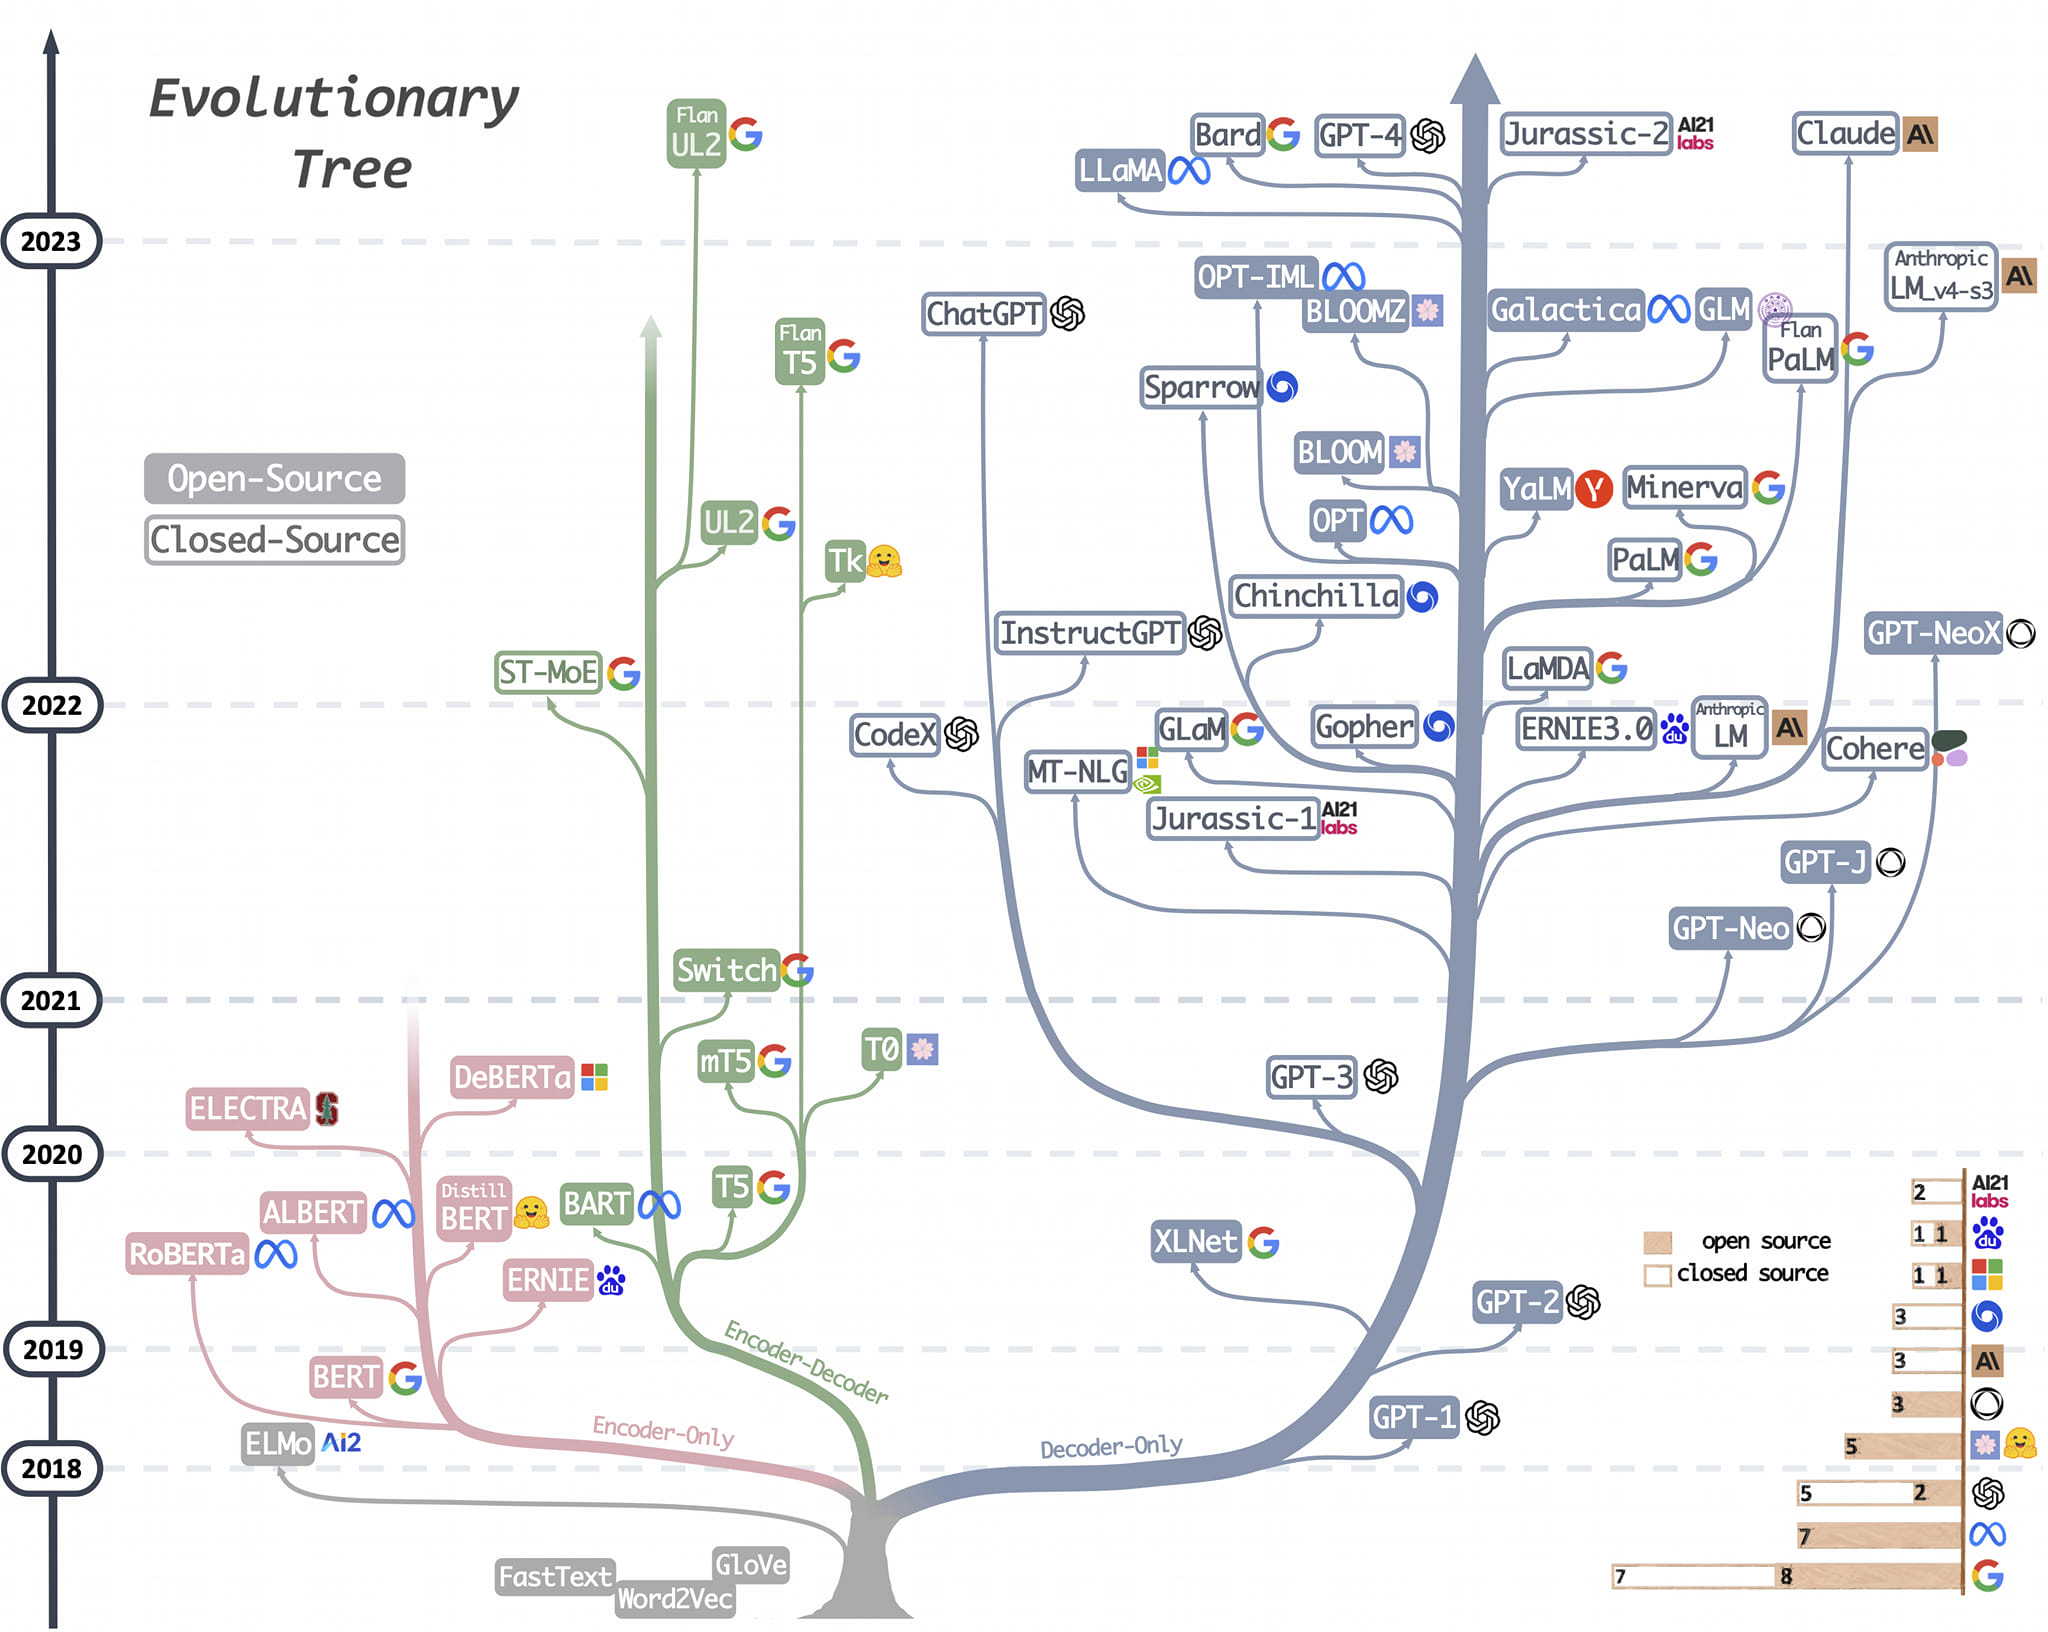
Fuente: Yann LeCun

Vamos a dejar la teoría de lado, ya que en una hora es imposible explicar lo que hace que funcionen modelos como estos, y nos enfocaremos en una aplicación en particular que es la clasificación de texto aplicada al problema de Imagen País.

## Instalación y carga de librerías

Vamos a empezar nuestro programa de Python instalando las librerías necesarias. En este caso, vamos a utilizar la implementación del Transformer disponible en [Huggingface](https://huggingface.co/), en particular, aquellos módulos que nos permiten entrenar modelos preentreandos como BERT, distilBERT o roBERTa con nuestros datos, tarea que se llama *Fine-Tunning*.

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.4 MB/s eta 0:00:00


In [ ]:
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 112.5 MB/s eta 0:00:00


In [ ]:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 1.6 MB/s eta 0:00:00


In [ ]:
# Para datos
import pandas as pd
import numpy as np

# Para PLN
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix, accuracy_score, f1_score, balanced_accuracy_score, matthews_corrcoef
from sklearn.utils import class_weight

# Para NN
import torch

# Huggingface
from datasets import Dataset, ClassLabel, Features, Value, load_dataset
from transformers import AutoTokenizer, AutoModel, TFAutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, IntervalStrategy

# Para utilidades
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import pprint

Aquí definimos unas funciones de utilidad:


1.   Para calcular e impirmir métricas de rendimiento de nuestro modelo.
2.   Para graficar una matriz de confusión.



## Definición de métricas de desempeño

In [ ]:
def compute_metrics(p):
	pred, labels = p
	pred = np.argmax(pred, axis=1)
	accuracy = accuracy_score(y_true=labels, y_pred=pred)
	balanced_accuracy = balanced_accuracy_score(y_true=labels, y_pred=pred)
	matthews_corr = matthews_corrcoef(y_true=labels, y_pred=pred)
	f1 = f1_score(y_true=labels, y_pred=pred, average = 'weighted')
	return {"accuracy": accuracy, "balanced_accuracy": balanced_accuracy, "matthews_corr": matthews_corr, "f1": f1}

In [ ]:
def plot_confusion_matrix(y_pred, y_true, labels):
	cm = confusion_matrix(y_true, y_pred, normalize = 'true')
	fig, ax = plt.subplots(figsize=(12,12))
	disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
	disp.plot(cmap = 'Blues', values_format = '.2f', ax = ax, colorbar= True, xticks_rotation = 45, text_kw = {'fontsize': 8})
	plt.title('Normalized Confusion Matrix')
	plt.show()

In [ ]:
def print_eval_metrics(y_valid, y_pred):
	metrics = {}
	metrics['f1'] = f1_score(y_valid, y_pred, average = 'weighted')
	metrics['acc'] = accuracy_score(y_valid, y_pred)
	metrics['bal_acc'] = balanced_accuracy_score(y_valid, y_pred)
	metrics['mat'] = matthews_corrcoef(y_valid, y_pred)
	pprint.pprint(metrics)

## Definición del modelo de entrenamiento

Finalmente definimos nuestro modelo. La idea es la siguiente:



1. Cargar el conjunto de datos al sistema.
2. Definir el modelo base (preentrenado) que vamos a ajustar con nuestros datos así como su tokenizador.
3. Definir el número de etiquetas (o clases) y la tarea a realizar con el modelo.
4. Definir el modelo y sus parámetros.
5. Evaluar el modelo.



In [ ]:
# --- load data ---
dataset = load_dataset('csv',  data_files={"train": 'immx-ibero-train.csv', "test": "immx-ibero-test.csv", "eval": "immx-ibero-eval.csv"}, sep = ',')

print(dataset)

# --- model definition ---
model_ckpt = "bert-base-cased"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

num_labels = 3
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = num_labels, ignore_mismatched_sizes=True).to(device))

# --- tokenize dataset ---
def tokenize(batch):
	return tokenizer(batch['text'], padding=True, truncation = True)

tweets_encoded = dataset.map(tokenize, batched=True, batch_size = None)

# --- training parameters ---
# https://stackoverflow.com/questions/69087044/early-stopping-in-bert-trainer-instances

batch_size = 4
logging_steps = len(tweets_encoded) // batch_size
model_name = f'{model_ckpt}-finetuned-ibero-expo'
training_args = TrainingArguments(output_dir = model_name,
                              num_train_epochs = 20,
                              learning_rate = 2e-5,
                              # label = ['overall_sent'],
                              per_device_train_batch_size = batch_size,
                              per_device_eval_batch_size = batch_size,
                              weight_decay = 0.01,
                              evaluation_strategy = 'epoch',
                              save_strategy = 'epoch',
                              save_total_limit = 5,
                              push_to_hub = False,
                              metric_for_best_model = 'f1',
                              load_best_model_at_end = True,
                              disable_tqdm = False,
                              # logging_steps = logging_steps,
                              log_level = 'error')


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tweet', 'labels', 'text'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'tweet', 'labels', 'text'],
        num_rows: 50
    })
    eval: Dataset({
        features: ['id', 'tweet', 'labels', 'text'],
        num_rows: 50
    })
})


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [ ]:
# --- training the model---
trainer = Trainer(model = model,
                args = training_args,
                compute_metrics = compute_metrics,
                train_dataset = tweets_encoded['train'],
                eval_dataset = tweets_encoded['eval'],
                callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
                )

trainer.train();

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,Matthews Corr,F1
1,No log,0.792503,0.700000,0.709137,0.559252,0.694042
2,No log,0.994213,0.620000,0.629605,0.440413,0.616017
3,No log,1.417997,0.640000,0.640570,0.460805,0.631515
4,0.534500,1.903463,0.640000,0.633114,0.456142,0.639027


KeyboardInterrupt: ignored

In [ ]:
# --- model evaluation ---
preds_output = trainer.predict(tweets_encoded['test'])

y_pred = np.argmax(preds_output.predictions, axis=1)

y_valid = np.array(dataset['test']['labels'])

print_eval_metrics(y_valid, y_pred)

# --- print confusion matrix ---
plot_confusion_matrix(y_pred, y_valid, [0,1,2])